## Final Notebook with heatmap test

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

from fastai.vision import *

In [2]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
bs = 64

In [4]:
from pathlib import Path

In [5]:
path = Path('./data')
path

PosixPath('data')

### Data
Inspect Augmentations, using ImageList object

In [7]:
path_train = path/'train'
path_test = path/'test'

In [8]:
tfms = get_transforms(flip_vert=True, max_warp=0.1)

In [9]:
tfms = get_transforms(flip_vert=True, max_rotate=40, max_zoom=1.3, max_lighting=0.3, max_warp=0,
                      p_affine=1., p_lighting=1.)

get_transforms(
    
    do_flip: bool = True, 
    flip_vert: bool = False,  
    max_rotate: float = 10.0,
    max_zoom: float = 1.1,
    max_lighting: float = 0.2,
    max_warp: float = 0.2,
    p_affine: float = 0.75,
    p_lighting: float = 0.75,

In [10]:
src = ImageList.from_folder(path).split_by_rand_pct(0.2, seed=2)

In [11]:
def get_data(size, bs, padding_mode='reflection'):
    return (src.label_from_folder()
           .transform(tfms, size=size, padding_mode=padding_mode)
           .databunch(bs=bs).normalize(imagenet_stats))

### Plot for Inspecting Actual Augment Effects

In [12]:
data = get_data(112, bs)

In [13]:
def _plot(i, j, ax):
    x, y = data.train_ds[3]
    x.show(ax, y=y)

In [13]:
#plot_multi(_plot, 3, 3, figsize=(8, 8))

## Model Training: DenseNet121

In [14]:
torch.cuda.empty_cache()

In [17]:
gc.collect()
learn = cnn_learner(data, models.densenet121, metrics=error_rate)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


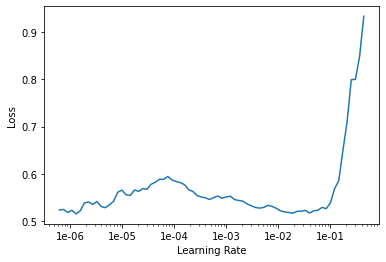

In [20]:
learn.lr_find()
learn.recorder.plot()

In [21]:
learn.fit_one_cycle(8, slice(1e-1/2), wd=0.1)

epoch,train_loss,valid_loss,error_rate,time
0,0.453480,0.615489,0.213961,00:14
1,0.462776,0.386284,0.161609,00:13
2,0.328956,0.262614,0.116844,00:13
3,0.277227,0.256851,0.102428,00:13
4,0.266246,0.272175,0.119120,00:13
5,0.233797,0.195444,0.084219,00:13
6,0.195634,0.181165,0.075114,00:13
7,0.165629,0.178969,0.074355,00:13


In [22]:
learn.save('final-112-dn121-stage1-93')

In [33]:
#learn.load('final-112-rn50-stage1-89')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


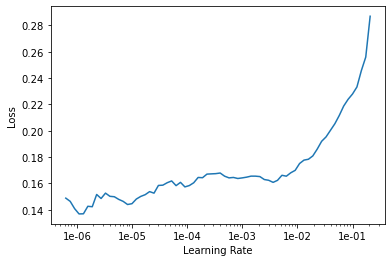

In [23]:
learn.lr_find()
learn.recorder.plot()

In [24]:
learn.unfreeze()
learn.fit_one_cycle(3, max_lr=1e-5, wd=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.172881,0.177643,0.071320,00:17
1,0.159942,0.176128,0.071320,00:16
2,0.154493,0.174901,0.069044,00:16


In [25]:
learn.save('final-112-dn121-stage2-93')

### Upsize Data

In [33]:
learn.load('final-112-dn121-stage2')

Learner(data=ImageDataBunch;

Train: LabelList (5276 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
malignant,malignant,malignant,malignant,malignant
Path: data;

Valid: LabelList (1318 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
malignant,benign,benign,benign,malignant
Path: data;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Sequential(
      (conv0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (norm0): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (norm1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runni

In [34]:
data = get_data(224, bs//2)
learn.data = data
learn.freeze()

In [35]:
torch.cuda.empty_cache()

epoch,train_loss,valid_loss,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


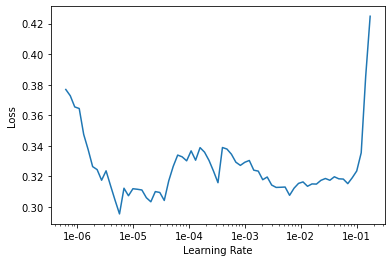

In [36]:
learn.lr_find()
learn.recorder.plot()

In [37]:
learn.fit_one_cycle(7, max_lr=slice(1e-4/2,1e-3/2), wd=0.2)

epoch,train_loss,valid_loss,error_rate,time
0,0.273633,0.238263,0.101669,00:32
1,0.241346,0.230559,0.097876,00:32
2,0.213434,0.200076,0.083460,00:32
3,0.199817,0.212016,0.094841,00:32
4,0.205863,0.204093,0.088771,00:32
5,0.198192,0.213580,0.093323,00:32
6,0.193944,0.195604,0.088771,00:32


In [62]:
learn.save('final-224-dn121-stage1')

In [39]:
learn.unfreeze()

In [40]:
learn.fit_one_cycle(6, max_lr=slice(1e-6, 1e-4), wd=0.5)

epoch,train_loss,valid_loss,error_rate,time
0,0.191785,0.201113,0.096358,00:43
1,0.189328,0.187741,0.088012,00:42
2,0.181424,0.187124,0.087253,00:42
3,0.173771,0.182398,0.081942,00:42
4,0.183846,0.193118,0.085736,00:42
5,0.174782,0.190775,0.081942,00:42


In [ ]:
learn.save('final-224-dn121-stage2-91')

## HeatMap
The heatmap is a visualization of the average activation of each pixel in the target image.

**Basic summary**:
1. Import pytorch hooks
2. Grab the data
3. Set the model to evaluation mode
4. Create the hooked backward function
5. Place the chosen item into a batch of one
6. Run hooked backward using this one item batch, recording the activations
7. Manipulate the hook to extract the activations and average them\
8. Create the heatmap function, which plots these activations with a colormap, over top of your original image
9. Call the heat map function


### Main code for Heatmap

## Start Here:
Get

Category malignant

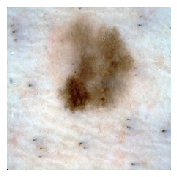

In [51]:
# just viewing the data
idx=1 # data to be heatmapped
x,y = data.valid_ds[idx]
x.show()
data.valid_ds.y[idx]

In [52]:
from fastai.callbacks.hooks import *  # import the pytorch hooks

In [53]:
data = get_data(224, 16) # grabs the whole dataset, why bs 16?

In [54]:
m = learn.model.eval(); # set model to eval mode, m[0] is the front of the model

In [55]:
def hooked_backward(cat=y):
    """
    Category=y is for predictions.  Applys the pytorch hooks to gather
    activations from the conv network that are normally thrown away.
    Does a prediction, then returns the hooks, with forward and back pass data.
    """
    with hook_output(m[0]) as hook_a: #m[0] first part of network
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(xb) # does a prediction
            preds[0, int(cat)].backward() # computes derivative of loss for pred
    return hook_a, hook_g # returns the activations in hooks

In [56]:
xb,_ = data.one_item(x) # pull single item from the data
xb_im = Image(data.denorm(xb)[0]) # possibly denormalize? 
xb = xb.cuda() # puts the xb in cuda memory

In [57]:
hook_a, hook_g = hooked_backward() # use the hook function

In [58]:
acts = hook_a.stored[0].cpu() # not sure what .cpu does
avg_acts = acts.mean(0) # avg the activations in first entry hook_a

In [59]:
def show_heatmap(hm):
    """
    hm is the averaged activations, 
    The function displays the original image, then
    displays the heatmap over top with lowered transparency.
    """
    _, ax = plt.subplots() 
    xb_im.show(ax) # fastai shows image
    ax.imshow(hm, alpha=0.6, extent=(0, 224, 224, 0), # put heatmap over top, extant
             interpolation='bilinear', cmap='magma');

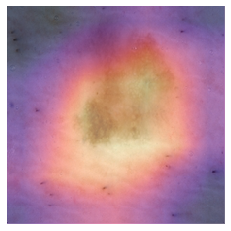

In [60]:
show_heatmap(avg_acts)

In [61]:
#learn.predict(x)

(Category malignant, tensor(1), tensor([0.0057, 0.9943]))

In [62]:
#data.valid_ds[idx]

(Image (3, 224, 224), Category malignant)